In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from cmcrameri import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle 
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
### get area, aa, aar for each o3region, O2region
# first calculate aa_infill_avg_product
all_data_gdf["aa_infill_avg_product"] = all_data_gdf["aar_infill_avg_product"]*all_data_gdf["Area"]

o3_df = pd.DataFrame(all_data_gdf.groupby('O3Region')['Area'].sum().rename('area'))
o3_df['aa'] = all_data_gdf.groupby('O3Region')[f'aa_infill_avg_product'].sum()
o3_df['aar'] = o3_df[f'aa']/o3_df['area']

o2_df = pd.DataFrame(all_data_gdf.groupby('O2Region')['Area'].sum().rename('area'))
o2_df['aa'] = all_data_gdf.groupby('O2Region')[f'aa_infill_avg_product'].sum()
o2_df['aar'] = o2_df[f'aa']/o2_df['area']

# remove the glaciers in O3Region=0 (these are glaciers that don't fit into any of the regions)
o3_df = o3_df.drop(0, axis=0).reset_index()
o2_df = o2_df.reset_index()
o2_df

,O2Region,area,aa,aar
0,2,14001.540,5184.415764,0.370275
1,3,1554.897,400.339139,0.257470
2,4,10749.719,4196.708084,0.390402
3,5,31321.245,14015.515589,0.447476
4,6,18663.934,7537.629073,0.403861


In [5]:
# define a 16-color categorical color palette
# http://vrl.cs.brown.edu/color
from matplotlib.colors import ListedColormap
# hex_codes = ["#a0e3b7", "#b33c85", "#37b51f", "#b32df9", "#7e9b3d", "#333dcd", "#c0e15c", "#fe7dda", "#235e31", "#be0332", "#20d8fd", "#6c3640", "#21f0b6", "#ec7f6a", "#0362a0", "#f79302"]
# hex_codes = ["#3c2d80", "#609111", "#e30293", "#20502e", "#ec102f", "#219571", "#ce5d8e", "#3d8bb7", "#b94403", "#a143f9", "#604020", "#577cf5", "#ae783e", "#4b03a9", "#9679a6", "#154975"]
hex_codes = ["#097969","#FF3131","#CC5500","#D2042D","#880808","#EC5800","#1434A4","#3d8bb7","#0000FF","#577cf5","#FFD700","#C4B454","#DA70D6","#702963","#9679a6","#9F2B68"]
cmap_16 = ListedColormap(hex_codes)

# create list of o3region numbers, names, hex codes
numbers = np.arange(1,17)
names = [ all_data_gdf[all_data_gdf['O3Region']==n]['O3_name'].values[0] for n in numbers]
colors = [ hex_codes[n-1] for n in numbers ]
names[11] = 'St Elias Mountains'

o3_info_df = pd.DataFrame({'Number':numbers, 'Name':names, 'Color':colors})
o3_info_df

,Number,Name,Color
0,1,Aleutian Range,#097969
1,2,Northern Aleutian Range,#FF3131
2,3,Western Alaska Range,#CC5500
3,4,Central Alaska Range,#D2042D
4,5,Eastern Alaska Range,#880808
5,6,Wrangell Mountains,#EC5800
6,7,Talkeetna Mountains,#1434A4
7,8,Southern Kenai Mountains,#3d8bb7
8,9,Northern Kenai Mountains,#0000FF
9,10,Western Chugach Mountains,#577cf5


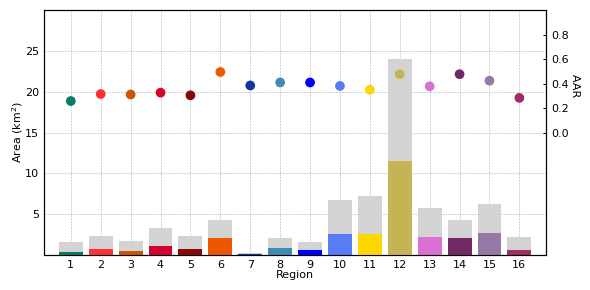

In [6]:
# add bar plot showing area, aa
fig,axs = plt.subplots(figsize=(6,3))

axs.bar(o3_df['O3Region'], o3_df['area'], color='lightgrey', zorder=2)
axs.bar(o3_df['O3Region'], o3_df['aa'], color=hex_codes, zorder=3)

# axs.set_yscale('log') ### this distorts the AAR visualization. can't have log scale
axs.set_xticks(np.arange(1,17))
axs.set_yticks([5000,10000,15000,20000,25000], [5,10,15,20,25])

axs.set_xlim(0.1,16.9)
axs.set_ylim(0,30000)
axs.set_xlabel("Region", size=8, labelpad=0)
axs.set_ylabel("Area (km$^2$)", size=8, labelpad=0)
axs.tick_params(axis='both', direction='in', length=0, labelsize=8)
axs.grid(zorder=1, linestyle='dashed', linewidth=0.4)

# twin x to plot aar of each
ax2 = axs.twinx()
ax2.scatter(o3_df['O3Region'], o3_df['aar'], color=hex_codes, zorder=4)

# format
ax2.set_ylim(-1,1)
ax2.set_yticks([0,0.2,0.4,0.6,0.8])
ax2.tick_params(axis='y', direction='in', length=2, labelsize=8)
ax2.set_ylabel("AAR                           ",
               loc='center', size=8, rotation=270, labelpad=8)

plt.tight_layout()

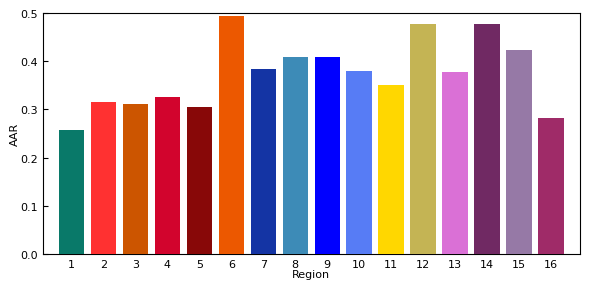

In [7]:
# add bar plot showing area, aa
fig,axs = plt.subplots(figsize=(6,3))
# axs.bar(o3_df['O3Region'], 1, width=1, color='lightgrey', zorder=2)
axs.bar(o3_df['O3Region'], o3_df['aar'], color=hex_codes, zorder=3)

# axs.set_yscale('log') ### this distorts the AAR visualization. can't have log scale
axs.set_xticks(np.arange(1,17))

axs.set_xlim(0.1,16.9)
axs.set_ylim(0,0.5)
axs.set_xlabel("Region", size=8, labelpad=0)
axs.set_ylabel("AAR", size=8, labelpad=0)
axs.tick_params(axis='both', direction='in', labelsize=8)
# axs.grid(zorder=1, linestyle='dashed', linewidth=1)

plt.tight_layout()

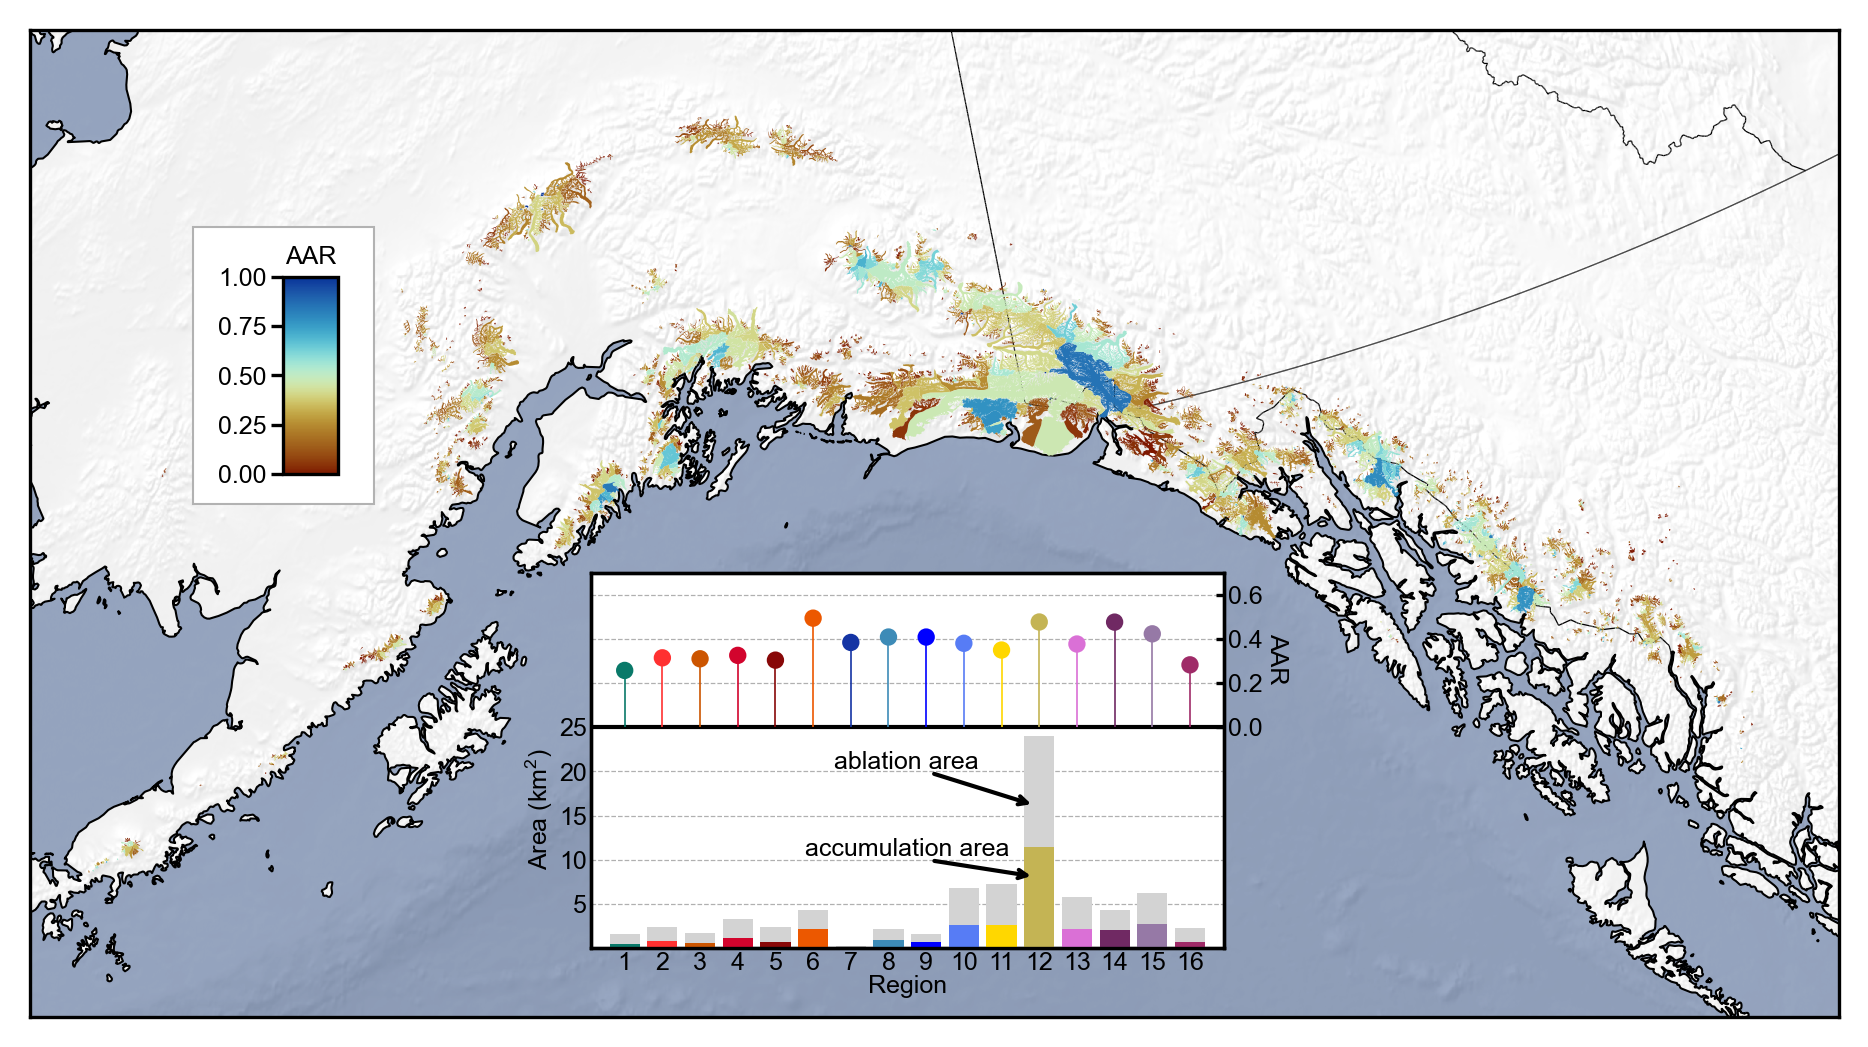

In [8]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

# start figure
fig,axs = snowFun.create_base_map(hillshade=1)

# create inset cbar axis
cb_ax = axs.inset_axes( (0.14,0.55,0.03,0.2), transform=axs.transAxes)

# add glacier data
im = all_data_gdf.plot(ax=axs, column='aar_avg_product', zorder=10, cmap=cm.roma, legend=True, vmin=0, vmax=1,
                          legend_kwds={"location":'left', 'cax':cb_ax, 'ticks':[0,0.25,0.5,0.75,1]})

# edit cbar axis
cb_ax.tick_params(labelsize=6, length=3, pad=1)
cb_ax.set_xlabel('AAR', size=6, labelpad=3)
cb_ax.xaxis.set_label_position('top') 

# add background to cbar axis
rect = Rectangle((0.09,0.52), 0.1, 0.28, transform=axs.transAxes,
                 fc ='white', ec ='black', lw=0.5, zorder=1.1)
axs.add_patch(rect)

# remove map ticks and labels
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")


# create inset axis for bar plot
ax_sc = axs.inset_axes( (0.31,0.07,0.35,0.38), transform=axs.transAxes)

# plot data
ax_sc.bar(o3_df['O3Region'], o3_df['area'], color='lightgrey', zorder=2)
ax_sc.bar(o3_df['O3Region'], o3_df['aa'], color=hex_codes, zorder=3)

# axs.set_yscale('log') ### this distorts the AAR visualization. can't have log scale
ax_sc.set_xticks(np.arange(1,17))
ax_sc.set_yticks([5000,10000,15000,20000,25000,30000,35000,40000],
                 [5,10,15,20,25,"","",""])

ax_sc.set_xlim(0.1,16.9)
ax_sc.set_ylim(0,42500)
ax_sc.set_xlabel("Region", size=6, labelpad=0)
ax_sc.set_ylabel("Area (km$^2$)               ", size=6, labelpad=1)
ax_sc.tick_params(axis='both', direction='in', length=0, labelsize=6, pad=1)
ax_sc.grid(axis='y', zorder=1, linestyle='dashed', linewidth=0.3)

# text and arrows to indicate accumulation and ablation
arr = mpatches.FancyArrowPatch((9, 10000), (12, 8000), zorder=4, arrowstyle='->,head_length=0.2,head_width=.1', mutation_scale=10)
ax_sc.add_patch(arr)
ax_sc.annotate("accumulation area", (.5, .5), fontsize=6, xytext=(-0.3,1), xycoords=arr, ha='center', va='bottom')


arr = mpatches.FancyArrowPatch((9, 20000), (12, 16000), zorder=4, arrowstyle='->,head_length=0.2,head_width=.1', mutation_scale=10)
ax_sc.add_patch(arr)
ax_sc.annotate("ablation area", (.5, .5), fontsize=6, xytext=(-0.3,1), xycoords=arr, ha='center', va='bottom')

# ax_sc.annotate('accumulation', xy=(12, 9000), xytext=(8, 10000), fontsize=5,
#             arrowprops=dict(facecolor='black', shrink=0))

# ax_sc.text(9,10000,'Accumulation', rotation=0, size=5)

# twin x to plot aar of each
ax2 = ax_sc.twinx()
ax2.scatter(o3_df['O3Region'], o3_df['aar'], s=10, color=hex_codes, zorder=4)

# vlines to make lollipops
ax2.vlines(np.arange(1,17), np.zeros(16), o3_df['aar'], color=hex_codes, linewidth=0.4)

# horizontal line to show the bottom
ax_sc.hlines([25000], [-1], [18], color='black', zorder=2, linewidth=1)

# format
ax2.set_ylim(-1,0.7)
ax2.set_yticks([0,0.2,0.4,0.6])
ax2.tick_params(axis='y', direction='in', length=2, labelsize=6, pad=1)
ax2.set_ylabel("AAR                             ", loc='center', size=6, rotation=270, labelpad=6)

out_path = os.path.join(folder_AGVA, 'Figures', 'aar map', 'aar_map_hillshade.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)


In [9]:
### print stats
total_area = np.nansum(all_data_gdf['Area'])
total_aa = np.nansum(all_data_gdf['aa_infill_avg_product'])
total_aar = total_aa/total_area

print("AA", total_aa)
print("AAR", total_aar)


AA 31334.6076486
AAR 0.4107230218031969


In [10]:
o3_df

,O3Region,area,aa,aar
0,1,1554.897,400.339139,0.257470
1,2,2359.375,742.287610,0.314612
2,3,1710.748,530.890323,0.310326
3,4,3275.767,1066.984232,0.325720
4,5,2323.194,706.472349,0.304095
5,6,4323.462,2137.468108,0.494388
6,7,263.569,101.283881,0.384278
7,8,2139.982,874.977371,0.408871
8,9,1595.633,652.166628,0.408720
9,10,6750.535,2568.280205,0.380456
